Groep 02 <br>
Jolan Grégoire 202399739 <br>
Gemaakte analyses:
- Gemakkelijk 1
- Gemiddeld 3
- Gevorderd 1

In [3]:
import numpy as np
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
from sqlalchemy import create_engine

# Gegevens voor de verbinding
server = "ARES"  # Servernaam of IP-adres van je SQL Server
database = "DEP1_DWH"  # Naam van je database

# Maak de verbindingsstring met Windows Authenticatie (Integrated Security)
engine = create_engine("mssql+pyodbc://@{}/{}?driver=ODBC+Driver+17+for+SQL+Server".format(server, database))

<h3>Gemakkelijk 1</h3>

DEEL 1

-- Stap 1: Voeg de kolom toe aan DimUser

``` sql
ALTER TABLE DimUser 
ADD UserType VARCHAR(100);
```

-- Stap 2: Update de kolom met de juiste waarden <br>

``` sql
UPDATE DimUser
SET UserType = 
    CASE 
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 0 
        THEN 'Met zonnepanelen'
        WHEN PVInstallationIndicator = 0 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 0 
        THEN 'Zonder zonnepanelen'
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 0 AND HeatPumpIndicator = 1 
        THEN 'Met warmtepomp en met zonnepanelen'
        WHEN PVInstallationIndicator = 1 AND ElectricVehicleIndicator = 1 AND HeatPumpIndicator = 0 
        THEN 'Met zonnepanelen en een thuisopladend elektrisch voertuig'
        WHEN PVInstallationIndicator = 0 AND ElectricVehicleIndicator = 1 AND HeatPumpIndicator = 0 
        THEN 'Zonder zonnepanelen en met een thuisopladend elektrisch voertuig'
    END;
```

controle:
``` sql
SELECT UserType, COUNT(*) 
FROM DimUser 
GROUP BY UserType;
```

In [5]:
sql = "SELECT UserType, COUNT(UserKey) AS NumberOfUsers FROM DimUser GROUP BY UserType"
df = pd.read_sql(sql, con=engine)
df.head()

,UserType,NumberOfUsers
0,Met zonnepanelen,300
1,Met warmtepomp en met zonnepanelen,300
2,Met zonnepanelen en een thuisopladend elektris...,300
3,Zonder zonnepanelen,300
4,Zonder zonnepanelen en met een thuisopladend e...,100


<Axes: xlabel='UserType', ylabel='NumberOfUsers'>

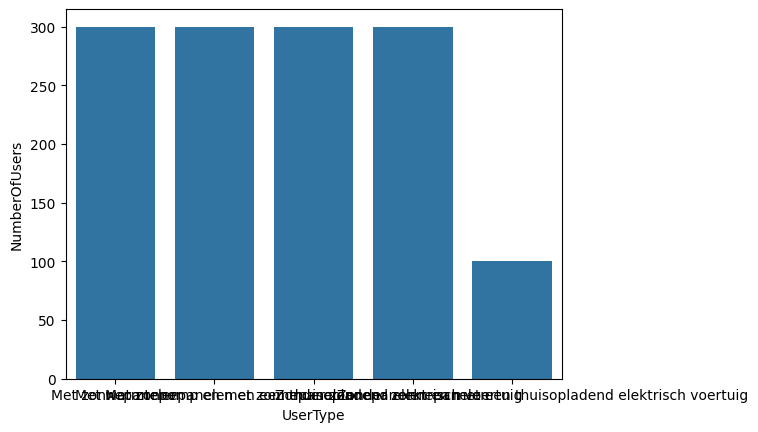

In [6]:
sns.barplot(x="UserType", y="NumberOfUsers", data=df)

DEEL 2

<h3>Gemiddeld 3</h3>

In [13]:
query = '''
SELECT fe.DateKey, fe.ConsumptionVolume_kWh
FROM FactEnergyUsage fe
JOIN DimUser u ON fe.UserKey = u.UserKey
WHERE u.UserType = 'Zonder zonnepanelen'
'''
#AND fe.DateKey BETWEEN 20240101 AND 20241231

df = pd.read_sql(query, con=engine)

df['DateKey'] = pd.to_datetime(df['DateKey'], format='%Y%m%d')
df['Month'] = df['DateKey'].dt.month

season_mapping = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
}

df['Season'] = df['Month'].map(season_mapping)
seasonal_consumption = df.groupby('Season')['ConsumptionVolume_kWh'].sum().reset_index()

print(seasonal_consumption)

   Season  ConsumptionVolume_kWh
0  Autumn              332355.14
1  Spring              313286.24
2  Summer              253664.81
3  Winter              505424.84


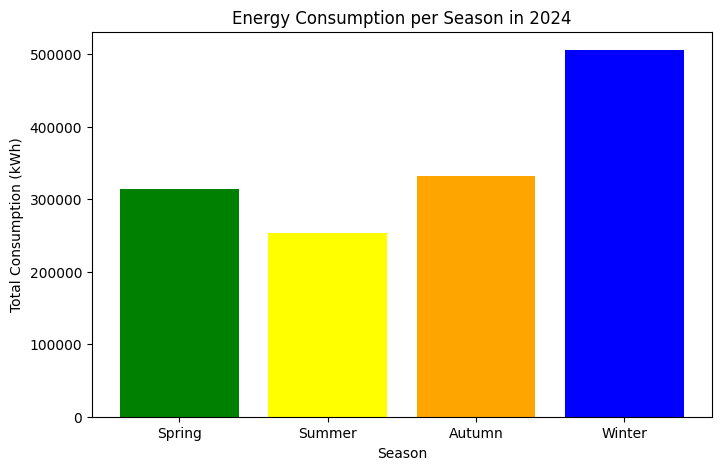

   Season  ConsumptionVolume_kWh
1  Spring              313286.24
2  Summer              253664.81
0  Autumn              332355.14
3  Winter              505424.84


In [14]:
season_order = ['Spring', 'Summer', 'Autumn', 'Winter']
seasonal_consumption['Season'] = pd.Categorical(seasonal_consumption['Season'], categories=season_order, ordered=True)
seasonal_consumption = seasonal_consumption.sort_values('Season')

# Barplot maken
plt.figure(figsize=(8, 5))
plt.bar(seasonal_consumption['Season'], seasonal_consumption['ConsumptionVolume_kWh'], color=['green', 'yellow', 'orange', 'blue'])
plt.xlabel('Season')
plt.ylabel('Total Consumption (kWh)')
plt.title('Energy Consumption per Season in 2024')
plt.show()

print(seasonal_consumption)

<h3>Gevorderd 1</h3>